# MTA Bus Performance & Violations Analysis Summary

This notebook analyzes MTA bus route performance and automated camera enforcement (ACE) violations in NYC. Key steps include data cleaning, aggregation, and visualization. 

**Main Insights:**
- Top and bottom bus routes by average road speed, highlighting borough differences.
- Impact of ACE: routes with violations vs. those without.
- Borough-level comparisons for high-performing routes.

Each section below presents essential code and visualizations supporting these findings.

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Read datasets
violations = pd.read_csv('MTA_Bus_Automated_Camera_Enforcement_Violations__Beginning_October_2019_20250917.csv')
speed = pd.read_csv('/Users/Marcy_Student/Desktop/marcy/Datathon/MTA_Bus_Route_Segment_Speeds__2023_-_2024_20250923.csv')

## EDA- Exploratory Data Analysis And Data Cleaning

In [ ]:
# Count missing values in each column of violations DataFrame
missing_values = violations.isnull().sum()
total_missing = violations.isnull().sum().sum()
print('Missing values per column in violations:')
print(missing_values)
print(f'Total missing values in violations: {total_missing}')

# Count missing values in each column of speed DataFrame
missing_values_speed = speed.isnull().sum()
total_missing_speed = speed.isnull().sum().sum()
print('Missing values per column in speed:')
print(missing_values_speed)
# columns names overview
violations.columns
speed.columns
# Show unique values and counts for bus route id
if 'Bus Route ID' in violations.columns:
    route_counts = violations['Bus Route ID'].value_counts(dropna=False)
    print('Unique values and counts for Bus Route ID:')
    print(route_counts)
else:
    print('Column "Bus Route Id" not found in violations DataFrame.')

Missing values per column in violations:
Violation ID                  0
Vehicle ID                66366
First Occurrence              0
Last Occurrence               0
Violation Status              0
Violation Type                0
Bus Route ID              10749
Violation Latitude            0
Violation Longitude           0
Stop ID                       0
Stop Name                     0
Bus Stop Latitude             0
Bus Stop Longitude            0
Violation Georeference        0
Bus Stop Georeference         0
dtype: int64
Total missing values in violations: 77115
Missing values per column in speed:
Year                                   0
Month                                  0
Timestamp                              0
Day of Week                            0
Hour of Day                            0
Route ID                               0
Direction                              0
Borough                                0
Route Type                             0
Stop Order         

In [7]:
# Filter violations for Bus Route IDs present from 2019 to 2025
violations['Year'] = pd.to_datetime(violations['Last Occurrence'], errors='coerce').dt.year
bus_route_years = violations.groupby('Bus Route ID')['Year'].agg(['min', 'max'])
valid_routes = bus_route_years[(bus_route_years['min'] <= 2019) & (bus_route_years['max'] >= 2025)].index
filtered_violations = violations[violations['Bus Route ID'].isin(valid_routes)]
filtered_violations['Bus Route ID'].nunique()

## in 2019, only 4 buses were implemented with ACE

/var/folders/bs/gtwb0lj97nb4v95968dmfzww0000gp/T/ipykernel_11612/185894737.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  violations['Year'] = pd.to_datetime(violations['Last Occurrence'], errors='coerce').dt.year


4

# ANALYSIS

In [8]:
speed.columns
# Create a new column in speed: Route ID with + if Route Type is not 'local'
speed['Route ID Modified'] = speed.apply(lambda row: str(row['Route ID']) + '+' if str(row['Route Type']).lower() != 'local' else row['Route ID'], axis=1)
speed[['Route ID', 'Route Type', 'Route ID Modified']].head()

,Route ID,Route Type,Route ID Modified
0,B6,Limited,B6+
1,B6,Limited,B6+
2,BX42,Local,BX42
3,BXM1,Express,BXM1+
4,BXM1,Express,BXM1+


In [68]:
# Grouping speed by Route ID Modified, year, month, direction, borough and aggregate averages
speed['Year'] = pd.to_datetime(speed['Timestamp'], errors='coerce').dt.year
speed['Month'] = pd.to_datetime(speed['Timestamp'], errors='coerce').dt.month
grouped_speed = speed.groupby(['Route ID Modified', 'Year', 'Month', 'Direction', 'Borough'], dropna=False).agg({
    'Average Road Speed': 'mean',
    'Average Travel Time': 'mean'
}).reset_index()
grouped_speed.head()

,Route ID Modified,Year,Month,Direction,Borough,Average Road Speed,Average Travel Time
0,B1,2023,1,N,Brooklyn,9.659854,8.935863
1,B1,2023,1,S,Brooklyn,8.195344,10.636164
2,B1,2023,2,N,Brooklyn,9.622038,8.984310
3,B1,2023,2,S,Brooklyn,8.218554,10.667293
4,B1,2023,3,N,Brooklyn,9.765665,8.949245


In [10]:
# Group violations by month of Last Occurrence, Bus Route ID, aggregated by count of Violation ID
violations['Month'] = pd.to_datetime(violations['Last Occurrence'], errors='coerce').dt.month
grouped_violations = violations.groupby(['Month', 'Bus Route ID'], dropna=False)['Violation ID'].count().reset_index()
grouped_violations.rename(columns={'Violation ID': 'Violation Count'}, inplace=True)
print(grouped_violations.head())

/var/folders/bs/gtwb0lj97nb4v95968dmfzww0000gp/T/ipykernel_11612/2731197716.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  violations['Month'] = pd.to_datetime(violations['Last Occurrence'], errors='coerce').dt.month


   Month Bus Route ID  Violation Count
0      1          B25             4970
1      1          B26             2589
2      1          B35             7629
3      1          B41             9707
4      1          B42             1110


In [74]:
# Rename columns to 'Bus_name' for consistency
grouped_violations.rename(columns={'Bus Route ID': 'Bus_name'}, inplace=True)
grouped_speed.rename(columns={'Route ID Modified': 'Bus_name'}, inplace=True)

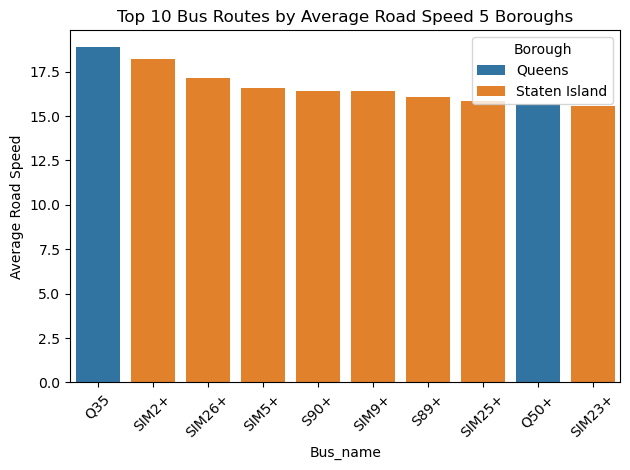

In [ ]:
# Barplot of top 10 distinct Bus_name aggregated by average road speed
big_boroughs = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx','Staten Island']
filtered_boroughs = grouped_speed[grouped_speed['Borough'].isin(big_boroughs)]
top10_busnames_boroughs = filtered_boroughs.groupby(['Bus_name', 'Borough'], as_index=False)['Average Road Speed'].mean().nlargest(10, 'Average Road Speed')
sns.barplot(data=top10_busnames_boroughs, x='Bus_name', y='Average Road Speed', hue='Borough')
plt.title('Top 10 Bus Routes by Average Road Speed 5 Boroughs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

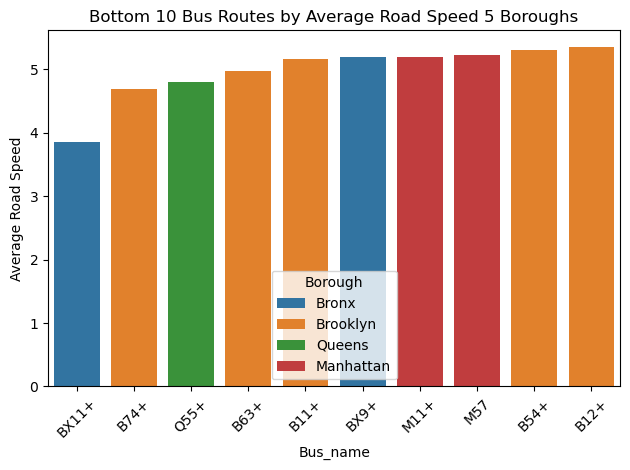

In [13]:
# Barplot of bottom 10 distinct Bus_name values aggregated by average road speed, only for Manhattan, Brooklyn, Queens, Bronx, Staten Island
bottom10_busnames_boroughs = filtered_boroughs.groupby(['Bus_name', 'Borough'], as_index=False)['Average Road Speed'].mean().nsmallest(10, 'Average Road Speed')
sns.barplot(data=bottom10_busnames_boroughs, x='Bus_name', y='Average Road Speed', hue='Borough')
plt.title('Bottom 10 Bus Routes by Average Road Speed 5 Boroughs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# MERGE grouped_violations and speed_violations

Vio_speed = pd.merge(grouped_speed,grouped_violations, how='left', on='Bus_name')
Vio_speed

,Bus_name,Year,Month_x,Direction,Borough,Average Road Speed,Average Travel Time,Month_y,Violation Count
0,B1,2023,1,N,Brooklyn,9.659854,8.935863,NaN,NaN
1,B1,2023,1,S,Brooklyn,8.195344,10.636164,NaN,NaN
2,B1,2023,2,N,Brooklyn,9.622038,8.984310,NaN,NaN
3,B1,2023,2,S,Brooklyn,8.218554,10.667293,NaN,NaN
4,B1,2023,3,N,Brooklyn,9.765665,8.949245,NaN,NaN
...,...,...,...,...,...,...,...,...,...
31079,X68+,2024,10,W,Queens,12.696511,20.344060,NaN,NaN
31080,X68+,2024,11,E,Queens,9.108831,26.485542,NaN,NaN
31081,X68+,2024,11,W,Queens,12.592638,20.559511,NaN,NaN
31082,X68+,2024,12,E,Queens,9.020379,26.612155,NaN,NaN


In [70]:
# Filter Vio_speed to only rows with at least 1 violation count
vio_speed_with_violations = Vio_speed[~Vio_speed['Violation Count'].isna()]
vio_speed_with_violations.head()

# Those are the buses that have ACE implemented

,Bus_name,Year,Month_x,Direction,Borough,Average Road Speed,Average Travel Time,Month_y,Violation Count
758,B25,2023,1,E,Brooklyn,7.115964,9.083726,1.0,4970.0
759,B25,2023,1,E,Brooklyn,7.115964,9.083726,2.0,3523.0
760,B25,2023,1,E,Brooklyn,7.115964,9.083726,3.0,4011.0
761,B25,2023,1,E,Brooklyn,7.115964,9.083726,4.0,3443.0
762,B25,2023,1,E,Brooklyn,7.115964,9.083726,5.0,4057.0


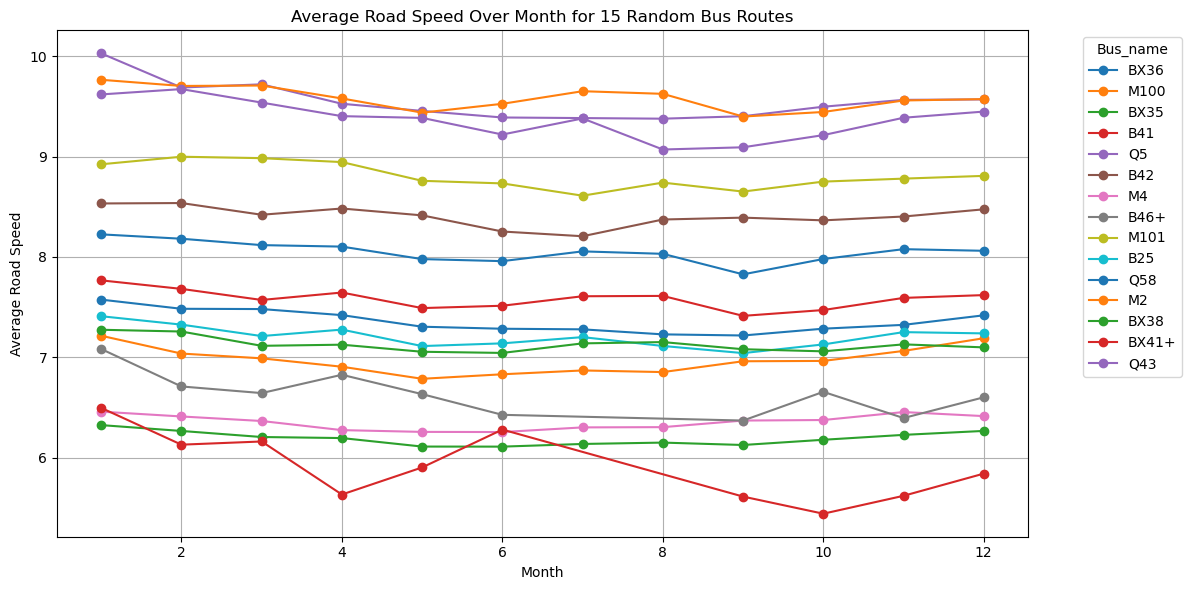

In [71]:
# Random sample of 10 unique bus names and plotting their average road speed over month
import random
unique_buses = vio_speed_with_violations['Bus_name'].unique()
sample_buses = random.sample(list(unique_buses), 15)
sample_data = vio_speed_with_violations[vio_speed_with_violations['Bus_name'].isin(sample_buses)]
monthly_avg_speed = sample_data.groupby(['Bus_name', 'Month_x'], as_index=False)['Average Road Speed'].mean()
plt.figure(figsize=(12, 6))
for bus in sample_buses:
    bus_data = monthly_avg_speed[monthly_avg_speed['Bus_name'] == bus]
    plt.plot(bus_data['Month_x'], bus_data['Average Road Speed'], marker='o', label=bus)
plt.title('Average Road Speed Over Month for 15 Random Bus Routes')
plt.xlabel('Month')
plt.ylabel('Average Road Speed')
plt.legend(title='Bus_name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

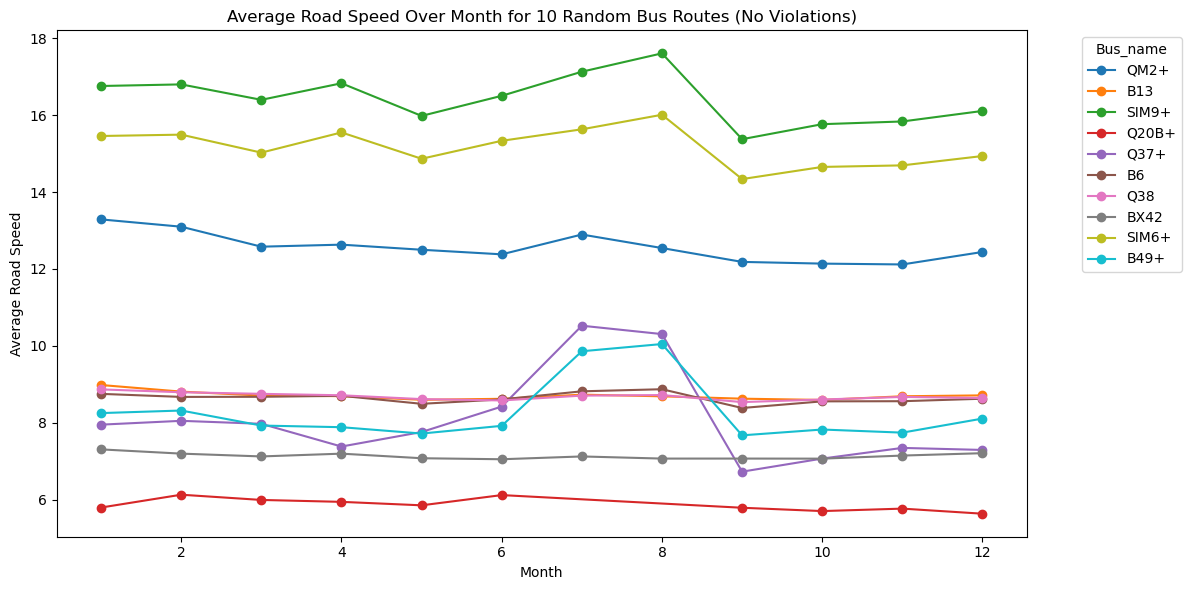

In [72]:
# Random sample of 10 unique bus names from vio_speed_without_violations and plotting their average road speed over month
vio_speed_without_violations = Vio_speed[Vio_speed['Violation Count'].isna() | (Vio_speed['Violation Count'] == 0)]
unique_buses_no_vio = vio_speed_without_violations['Bus_name'].unique()
sample_buses_no_vio = random.sample(list(unique_buses_no_vio), 10)
sample_data_no_vio = vio_speed_without_violations[vio_speed_without_violations['Bus_name'].isin(sample_buses_no_vio)]
monthly_avg_speed_no_vio = sample_data_no_vio.groupby(['Bus_name', 'Month_x'], as_index=False)['Average Road Speed'].mean()
plt.figure(figsize=(12, 6))
for bus in sample_buses_no_vio:
    bus_data = monthly_avg_speed_no_vio[monthly_avg_speed_no_vio['Bus_name'] == bus]
    plt.plot(bus_data['Month_x'], bus_data['Average Road Speed'], marker='o', label=bus)
plt.title('Average Road Speed Over Month for 10 Random Bus Routes (No Violations)')
plt.xlabel('Month')
plt.ylabel('Average Road Speed')
plt.legend(title='Bus_name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Grouping grouped_speed by Bus_name, aggregate by mean of Average Road Speed
bus_avg_speed = grouped_speed.groupby('Bus_name', as_index=False)['Average Road Speed'].mean().sort_values(by='Average Road Speed', ascending=True)
bus_avg_speed.head()

,Bus_name,Average Road Speed
97,BX11+,3.861361
74,B74+,4.683748
316,Q55+,4.800090
62,B63+,4.973795
6,B11+,5.164328


/var/folders/bs/gtwb0lj97nb4v95968dmfzww0000gp/T/ipykernel_11612/4084190387.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top3_per_borough = bus_borough_avg.groupby('Borough').apply(lambda x: x.nlargest(3, 'Average Road Speed')).reset_index(drop=True)


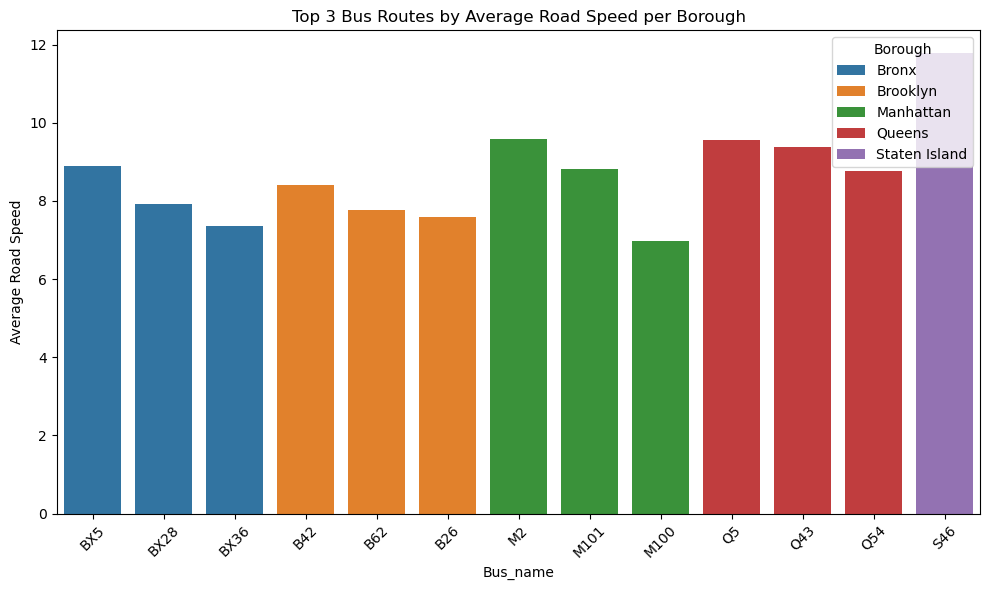

In [76]:
# Barplot of the 3 top high average road speed per borough Buses with ace

# Group by Bus_name and Borough, aggregate by mean average road speed
bus_borough_avg = vio_speed_with_violations.groupby(['Bus_name', 'Borough'], as_index=False)['Average Road Speed'].mean()

# For each borough, get top 3 bus routes by average road speed
top3_per_borough = bus_borough_avg.groupby('Borough').apply(lambda x: x.nlargest(3, 'Average Road Speed')).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=top3_per_borough, x='Bus_name', y='Average Road Speed', hue='Borough')
plt.title('Top 3 Bus Routes by Average Road Speed per Borough')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/bs/gtwb0lj97nb4v95968dmfzww0000gp/T/ipykernel_11612/728654730.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top3_per_borough_no_vio = bus_borough_avg_no_vio.groupby('Borough').apply(lambda x: x.nlargest(3, 'Average Road Speed')).reset_index(drop=True)


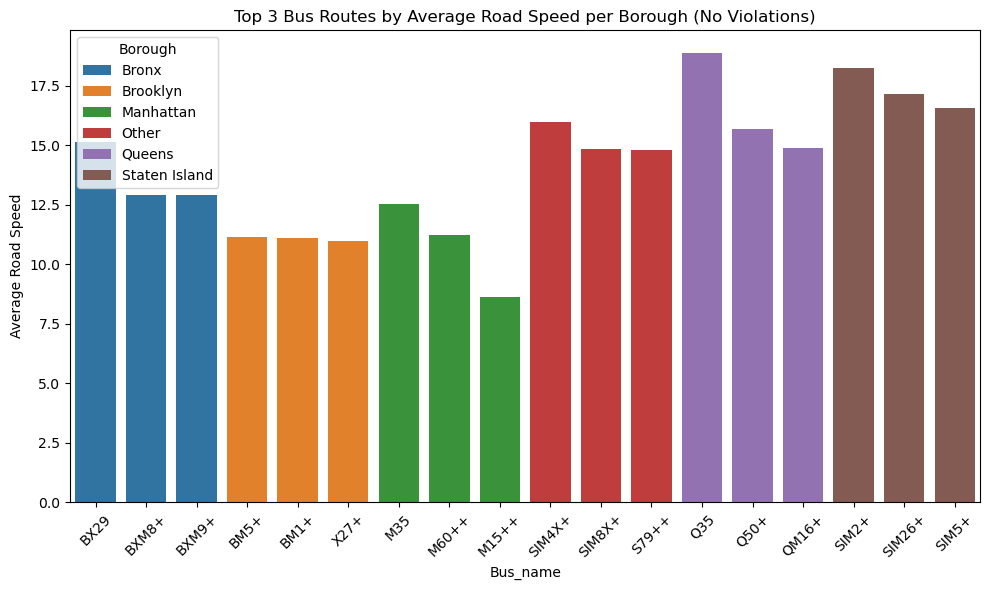

In [77]:
# Barplot of the 3 top high average road speed per borough Buses without ace
# Group by Bus_name and Borough, aggregate by mean average road speed
bus_borough_avg_no_vio = vio_speed_without_violations.groupby(['Bus_name', 'Borough'], as_index=False)['Average Road Speed'].mean()

# For each borough, get top 3 bus routes by average road speed
top3_per_borough_no_vio = bus_borough_avg_no_vio.groupby('Borough').apply(lambda x: x.nlargest(3, 'Average Road Speed')).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=top3_per_borough_no_vio, x='Bus_name', y='Average Road Speed', hue='Borough')
plt.title('Top 3 Bus Routes by Average Road Speed per Borough (No Violations)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Loading a new dataset, MTA bus speeds, because the segment speed bus only have data in 2023

In [78]:
speed_2 = pd.read_csv('MTA_Bus_Speeds__2020_-_2024_20250924.csv')
speed_2.head()


,month,borough,day_type,trip_type,route_id,period,total_mileage,total_operating_time,average_speed
0,2020-01-01,Bronx,1,LCL/LTD,BX1,Off-Peak,21090.045,3085,6.835836
1,2020-01-01,Bronx,1,LCL/LTD,BX1,Peak,8898.787,1360,6.542821
2,2020-01-01,Bronx,2,LCL/LTD,BX1,Off-Peak,7162.781,1018,7.035971
3,2020-01-01,Bronx,2,LCL/LTD,BX1,Peak,2749.674,395,6.956308
4,2020-01-01,Bronx,1,LCL/LTD,BX10,Off-Peak,23386.701,2678,8.732065


In [79]:
# Count unique bus names in violations
unique_bus_names = violations['Bus Route ID'].nunique()
print(f'Number of unique bus names in violations: {unique_bus_names}')
# Merge speed_2 with grouped_violations on route_id (speed_2) and bus_name (grouped_violations), keeping all rows from speed_2
merged_speed2_violations = pd.merge(speed_2, grouped_violations, left_on='route_id', right_on='Bus_name', how='left')
merged_speed2_violations.head()

Number of unique bus names in violations: 40


,month,borough,day_type,trip_type,route_id,period,total_mileage,total_operating_time,average_speed,Month,Bus_name,Violation Count
0,2020-01-01,Bronx,1,LCL/LTD,BX1,Off-Peak,21090.045,3085,6.835836,NaN,NaN,NaN
1,2020-01-01,Bronx,1,LCL/LTD,BX1,Peak,8898.787,1360,6.542821,NaN,NaN,NaN
2,2020-01-01,Bronx,2,LCL/LTD,BX1,Off-Peak,7162.781,1018,7.035971,NaN,NaN,NaN
3,2020-01-01,Bronx,2,LCL/LTD,BX1,Peak,2749.674,395,6.956308,NaN,NaN,NaN
4,2020-01-01,Bronx,1,LCL/LTD,BX10,Off-Peak,23386.701,2678,8.732065,NaN,NaN,NaN


In [80]:
# Count route_id in merged_speed2_violations with no violation count (NaN or 0)
no_violation_routes = merged_speed2_violations[(merged_speed2_violations['Violation Count'].isna())]
num_no_violation_routes = no_violation_routes['route_id'].nunique()
print(f'Number of route_id without violation count: {num_no_violation_routes}')

Number of route_id without violation count: 299


In [28]:
# List all unique route_id in merged_speed2_violations
unique_route_ids = merged_speed2_violations['route_id'].unique()
print('Unique route_id in merged_speed2_violations:')
print(unique_route_ids)
len(unique_route_ids)

Unique route_id in merged_speed2_violations:
['BX1' 'BX10' 'BX11' 'BX12' 'BX12+' 'BX13' 'BX15' 'BX16' 'BX17' 'BX18'
 'BX19' 'BX2' 'BX20' 'BX21' 'BX22' 'BX23' 'BX24' 'BX26' 'BX27' 'BX28'
 'BX29' 'BX3' 'BX30' 'BX31' 'BX32' 'BX33' 'BX34' 'BX35' 'BX36' 'BX38'
 'BX39' 'BX4' 'BX40' 'BX41' 'BX41+' 'BX42' 'BX46' 'BX4A' 'BX5' 'BX6'
 'BX6+' 'BX7' 'BX8' 'BX9' 'BXM1' 'BXM10' 'BXM11' 'BXM18' 'BXM2' 'BXM3'
 'BXM4' 'BXM6' 'BXM7' 'BXM8' 'BXM9' 'B1' 'B100' 'B103' 'B11' 'B12' 'B13'
 'B14' 'B15' 'B16' 'B17' 'B2' 'B20' 'B24' 'B25' 'B26' 'B3' 'B31' 'B32'
 'B35' 'B36' 'B37' 'B38' 'B39' 'B4' 'B41' 'B42' 'B43' 'B44' 'B44+' 'B45'
 'B46' 'B46+' 'B47' 'B48' 'B49' 'B52' 'B54' 'B57' 'B6' 'B60' 'B61' 'B62'
 'B63' 'B64' 'B65' 'B67' 'B68' 'B69' 'B7' 'B70' 'B74' 'B8' 'B82' 'B82+'
 'B83' 'B84' 'B9' 'BM1' 'BM2' 'BM3' 'BM4' 'BM5' 'X27' 'X28' 'X37' 'X38'
 'M1' 'M10' 'M100' 'M101' 'M102' 'M103' 'M104' 'M106' 'M11' 'M116' 'M12'
 'M14A+' 'M14D+' 'M15' 'M15+' 'M2' 'M20' 'M21' 'M22' 'M23+' 'M3' 'M31'
 'M34+' 'M34A+' 'M35' 'M4'

337

In [ ]:
ace_buses_speed = pd.merge(speed_2, grouped_violations, left_on='route_id', right_on='Bus_name', how='right')
ace_buses_speed.head()
# Drop 'Month' column from ace_buses_speed

ace_buses_speed = ace_buses_speed.drop(columns=['Month'])


In [83]:
ace_buses_speed.head()

,month,borough,day_type,trip_type,route_id,period,total_mileage,total_operating_time,average_speed,Bus_name,Violation Count
0,2020-01-01,Brooklyn,1.0,LCL/LTD,B25,Off-Peak,17547.266,2850.0,6.155636,B25,4970
1,2020-01-01,Brooklyn,1.0,LCL/LTD,B25,Peak,6676.507,1214.0,5.497178,B25,4970
2,2020-01-01,Brooklyn,2.0,LCL/LTD,B25,Off-Peak,6361.486,926.0,6.862979,B25,4970
3,2020-01-01,Brooklyn,2.0,LCL/LTD,B25,Peak,2336.101,361.0,6.456563,B25,4970
4,2020-02-01,Brooklyn,1.0,LCL/LTD,B25,Off-Peak,15533.034,2529.0,6.140402,B25,4970


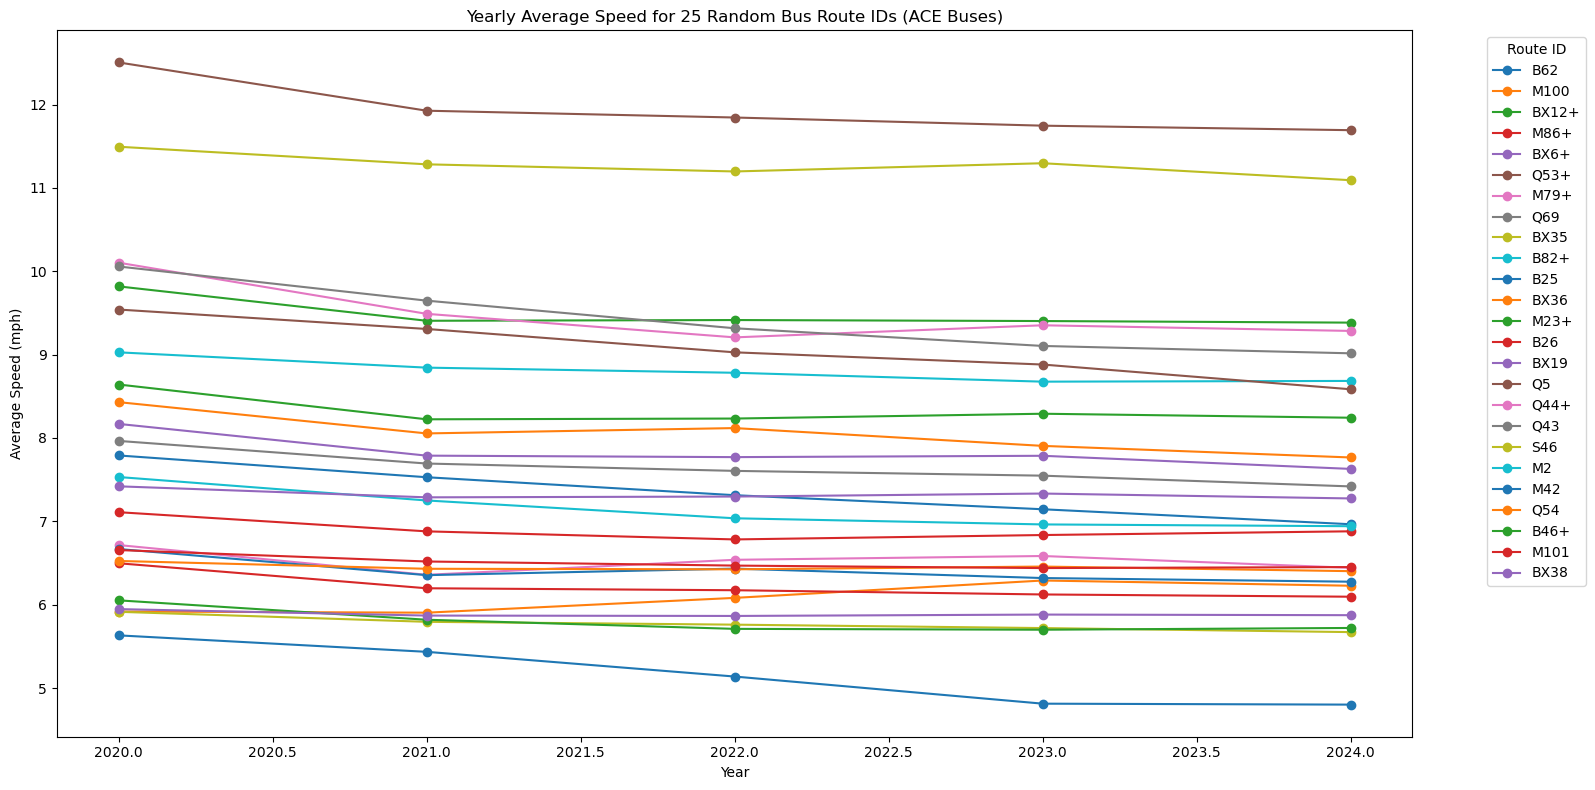

In [85]:
# Random 25 route_id and plotting their average speed yearly
import random
# Ensure month column is datetime
ace_buses_speed['month'] = pd.to_datetime(ace_buses_speed['month'], errors='coerce')
ace_buses_speed['year'] = ace_buses_speed['month'].dt.year
    # Get 25 random route_ids
route_ids = ace_buses_speed['route_id'].dropna().unique()
sample_routes = random.sample(list(route_ids), min(25, len(route_ids)))
# Filter data for sampled routes
sample_data = ace_buses_speed[ace_buses_speed['route_id'].isin(sample_routes)]
# Group by route_id and year, calculate average speed
avg_speed_yearly = sample_data.groupby(['route_id', 'year'], as_index=False)['average_speed'].mean()
plt.figure(figsize=(16, 8))
for route in sample_routes:
    route_data = avg_speed_yearly[avg_speed_yearly['route_id'] == route]
    plt.plot(route_data['year'], route_data['average_speed'], marker='o', label=str(route))
plt.title('Yearly Average Speed for 25 Random Bus Route IDs (ACE Buses)')
plt.xlabel('Year')
plt.ylabel('Average Speed (mph)')
plt.legend(title='Route ID', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()

In [32]:
# ANOVA test: difference in yearly average speed for 25 random ACE bus routes (2020-2024)
from scipy.stats import f_oneway
anova_years = [2020, 2021, 2022, 2023, 2024]
anova_data = []
for year in anova_years:
    speeds = avg_speed_yearly[avg_speed_yearly['year'] == year]['average_speed'].dropna()
    anova_data.append(speeds)
if all(len(group) > 0 for group in anova_data):
    f_stat, p_value = f_oneway(*anova_data)
    print(f'ANOVA F-statistic: {f_stat:.3f}, p-value: {p_value:.4f}')
    if p_value < 0.05:
        print('There is a significant difference in yearly average speeds among ACE bus routes (2020-2024).')
    else:
        print('No significant difference in yearly average speeds among ACE bus routes (2020-2024).')
else:
    print('Not all years have data for ANOVA test.')

ANOVA F-statistic: 0.298, p-value: 0.8788
No significant difference in yearly average speeds among ACE bus routes (2020-2024).


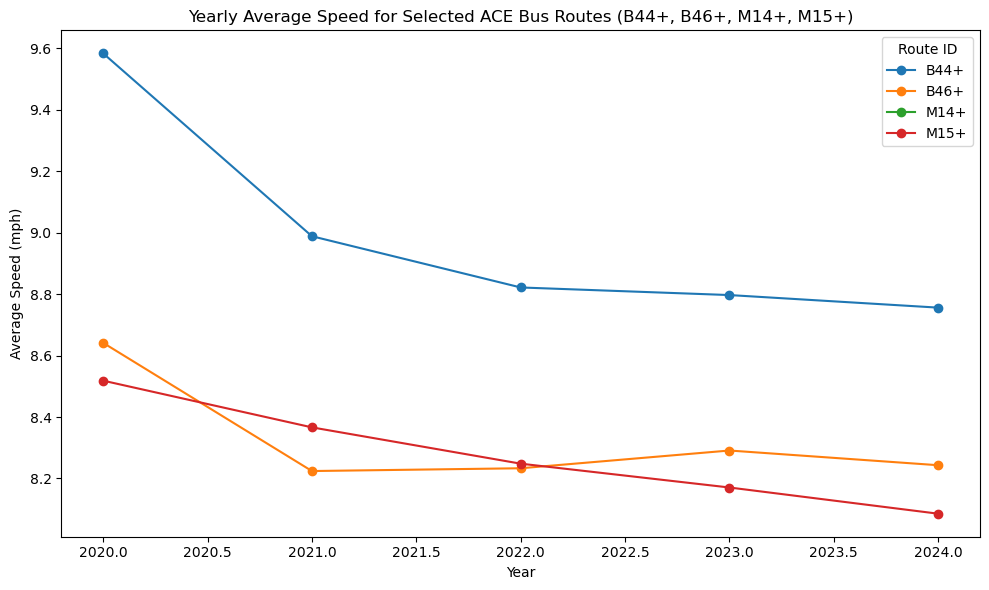

In [86]:
# Lineplot for yearly average speed of B44+, B46+, M14+, M15+ in ace_buses_speed, the 4 first 4 buses that started the ace program

selected_routes = ['B44+', 'B46+', 'M14+', 'M15+']
if 'month' in ace_buses_speed.columns:
    ace_buses_speed['month'] = pd.to_datetime(ace_buses_speed['month'], errors='coerce')
    ace_buses_speed['year'] = ace_buses_speed['month'].dt.year
    filtered_data = ace_buses_speed[ace_buses_speed['route_id'].isin(selected_routes)]
    avg_speed_yearly = filtered_data.groupby(['route_id', 'year'], as_index=False)['average_speed'].mean()
    plt.figure(figsize=(10, 6))
    for route in selected_routes:
        route_data = avg_speed_yearly[avg_speed_yearly['route_id'] == route]
        plt.plot(route_data['year'], route_data['average_speed'], marker='o', label=route)
    plt.title('Yearly Average Speed for Selected ACE Bus Routes (B44+, B46+, M14+, M15+)')
    plt.xlabel('Year')
    plt.ylabel('Average Speed (mph)')
    plt.legend(title='Route ID')
    plt.tight_layout()
    plt.show()
else:
    print("month column not found in ace_buses_speed.")

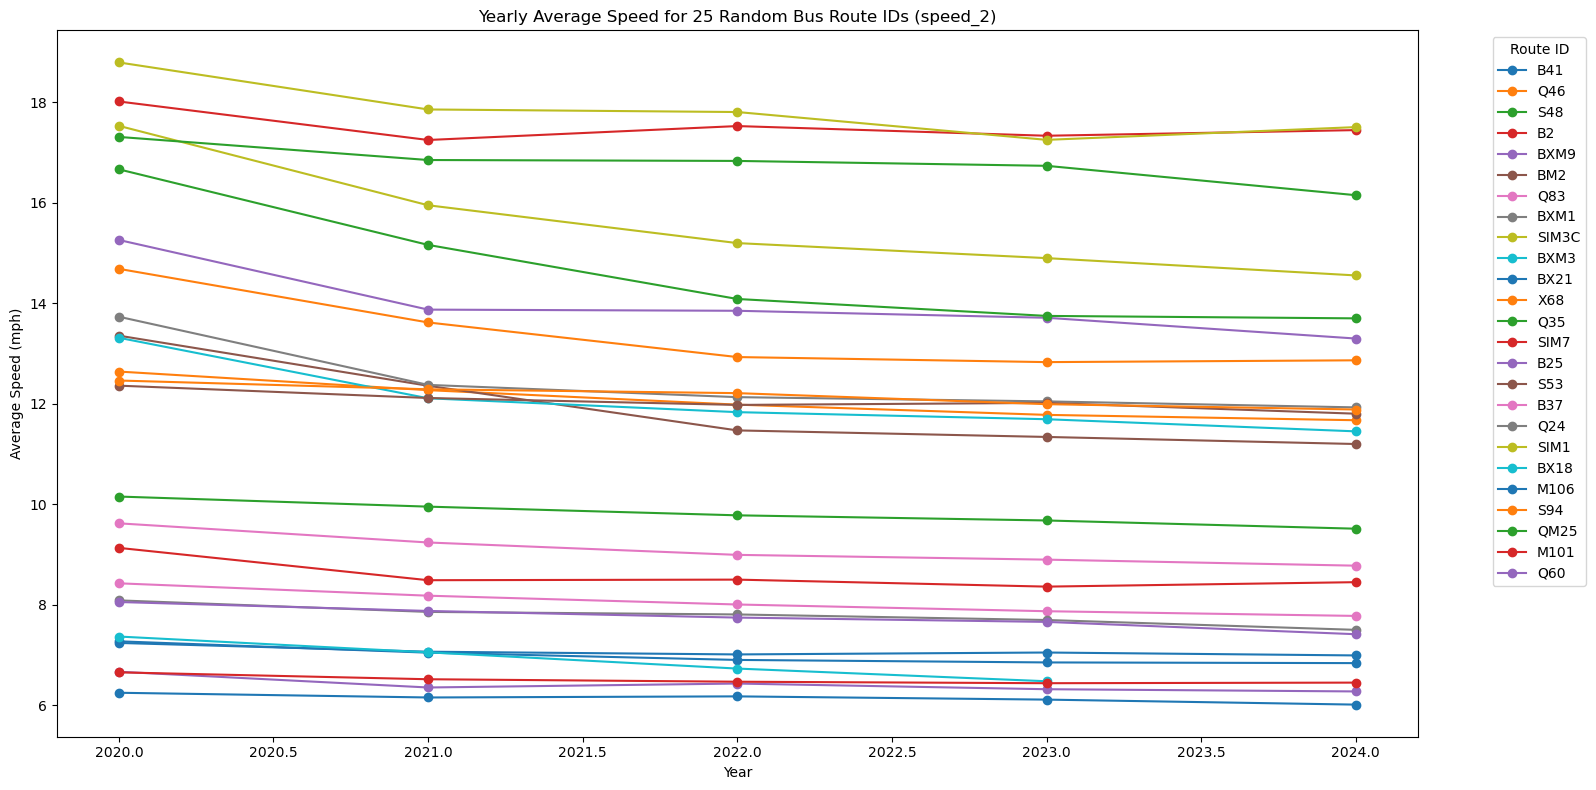

In [87]:
# Lineplot for yearly average speed of 25 random route_ids in speed_2
import random
if 'month' in speed_2.columns:
    speed_2['month'] = pd.to_datetime(speed_2['month'], errors='coerce')
    speed_2['year'] = speed_2['month'].dt.year
    route_ids = speed_2['route_id'].dropna().unique()
    sample_routes = random.sample(list(route_ids), min(25, len(route_ids)))
    sample_data = speed_2[speed_2['route_id'].isin(sample_routes)]
    avg_speed_yearly = sample_data.groupby(['route_id', 'year'], as_index=False)['average_speed'].mean()
    plt.figure(figsize=(16, 8))
    for route in sample_routes:
        route_data = avg_speed_yearly[avg_speed_yearly['route_id'] == route]
        plt.plot(route_data['year'], route_data['average_speed'], marker='o', label=str(route))
    plt.title('Yearly Average Speed for 25 Random Bus Route IDs (speed_2)')
    plt.xlabel('Year')
    plt.ylabel('Average Speed (mph)')
    plt.legend(title='Route ID', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    plt.tight_layout()
    plt.show()
else:
    print("month column not found in speed_2.")

Top 5 route_id by average speed and their total violation counts:
Route: S79+, Total Violation Count: 6038371
Route: Q53+, Total Violation Count: 8814720
Route: S46, Total Violation Count: 9984720
Route: M60+, Total Violation Count: 23901626
Route: BX12+, Total Violation Count: 44044042


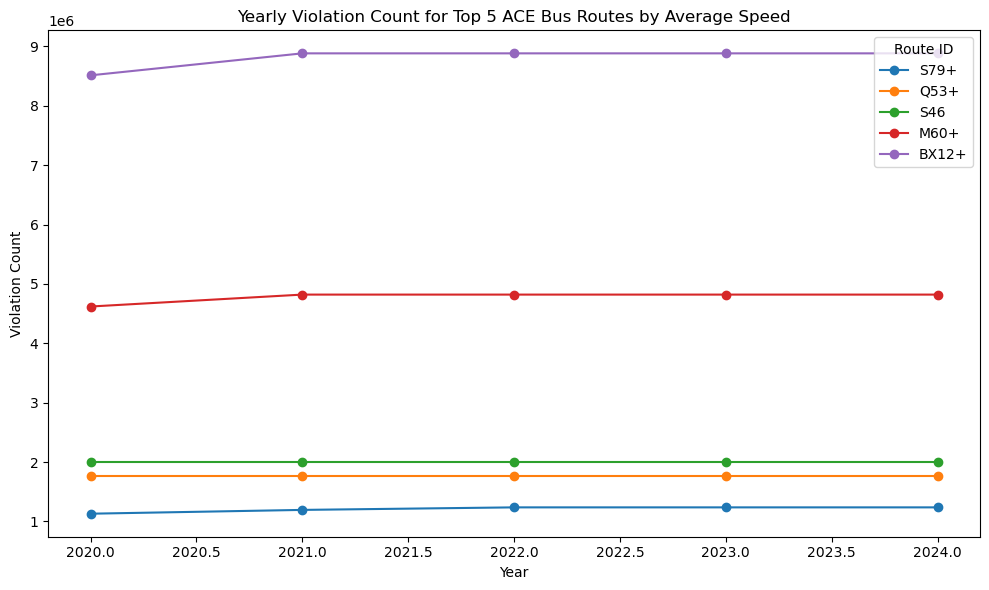

In [88]:
# Top 5 unique route_id in ace_buses_speed by average speed and their violation counts
if 'route_id' in ace_buses_speed.columns and 'average_speed' in ace_buses_speed.columns and 'Violation Count' in ace_buses_speed.columns and 'month' in ace_buses_speed.columns:
    ace_buses_speed['month'] = pd.to_datetime(ace_buses_speed['month'], errors='coerce')
    ace_buses_speed['year'] = ace_buses_speed['month'].dt.year
    avg_speed_per_route = ace_buses_speed.groupby('route_id', as_index=False)['average_speed'].mean()
    top5_routes = avg_speed_per_route.nlargest(5, 'average_speed')['route_id']
    top5_data = ace_buses_speed[ace_buses_speed['route_id'].isin(top5_routes)]
    # Print route_id and violation counts
    violation_counts = top5_data.groupby('route_id')['Violation Count'].sum()
    print('Top 5 route_id by average speed and their total violation counts:')
    for route in top5_routes:
        print(f'Route: {route}, Total Violation Count: {violation_counts.get(route, 0)}')
    # Plot violation count over year for each route
    yearly_vio = top5_data.groupby(['route_id', 'year'], as_index=False)['Violation Count'].sum()
    plt.figure(figsize=(10, 6))
    for route in top5_routes:
        route_data = yearly_vio[yearly_vio['route_id'] == route]
        plt.plot(route_data['year'], route_data['Violation Count'], marker='o', label=str(route))
    plt.title('Yearly Violation Count for Top 5 ACE Bus Routes by Average Speed')
    plt.xlabel('Year')
    plt.ylabel('Violation Count')
    plt.legend(title='Route ID')
    plt.tight_layout()
    plt.show()
else:
    print("Required columns not found in ace_buses_speed.")

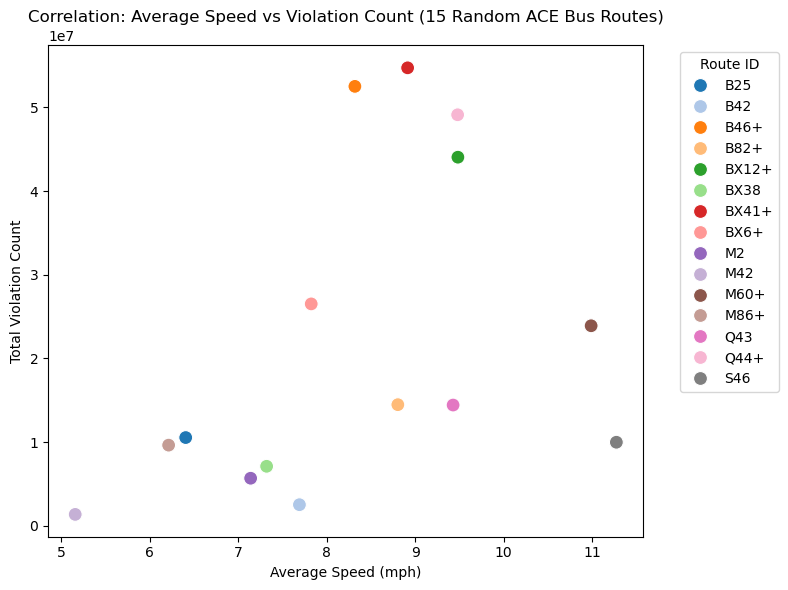

Pearson correlation coefficient: 0.417, p-value: 0.1223
No statistically significant correlation between average speed and violation count.


In [89]:
# Correlation plot for 15 random route_ids in ace_buses_speed: speed vs violation count
import random
if 'route_id' in ace_buses_speed.columns and 'average_speed' in ace_buses_speed.columns and 'Violation Count' in ace_buses_speed.columns:
    route_ids = ace_buses_speed['route_id'].dropna().unique()
    sample_routes = random.sample(list(route_ids), min(15, len(route_ids)))
    sample_data = ace_buses_speed[ace_buses_speed['route_id'].isin(sample_routes)]
    # Group by route_id, calculate mean speed and total violation count
    corr_data = sample_data.groupby('route_id', as_index=False).agg({'average_speed': 'mean', 'Violation Count': 'sum'})
    # Plot correlation scatterplot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=corr_data, x='average_speed', y='Violation Count', hue='route_id', palette='tab20', s=100)
    plt.title('Correlation: Average Speed vs Violation Count (15 Random ACE Bus Routes)')
    plt.xlabel('Average Speed (mph)')
    plt.ylabel('Total Violation Count')
    plt.legend(title='Route ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    # Statistical analysis: Pearson correlation
    from scipy.stats import pearsonr
    corr_coef, p_value = pearsonr(corr_data['average_speed'], corr_data['Violation Count'])
    print(f'Pearson correlation coefficient: {corr_coef:.3f}, p-value: {p_value:.4f}')
    if p_value < 0.05:
        print('There is a statistically significant correlation between average speed and violation count.')
    else:
        print('No statistically significant correlation between average speed and violation count.')
else:
    print("Required columns not found in ace_buses_speed.")

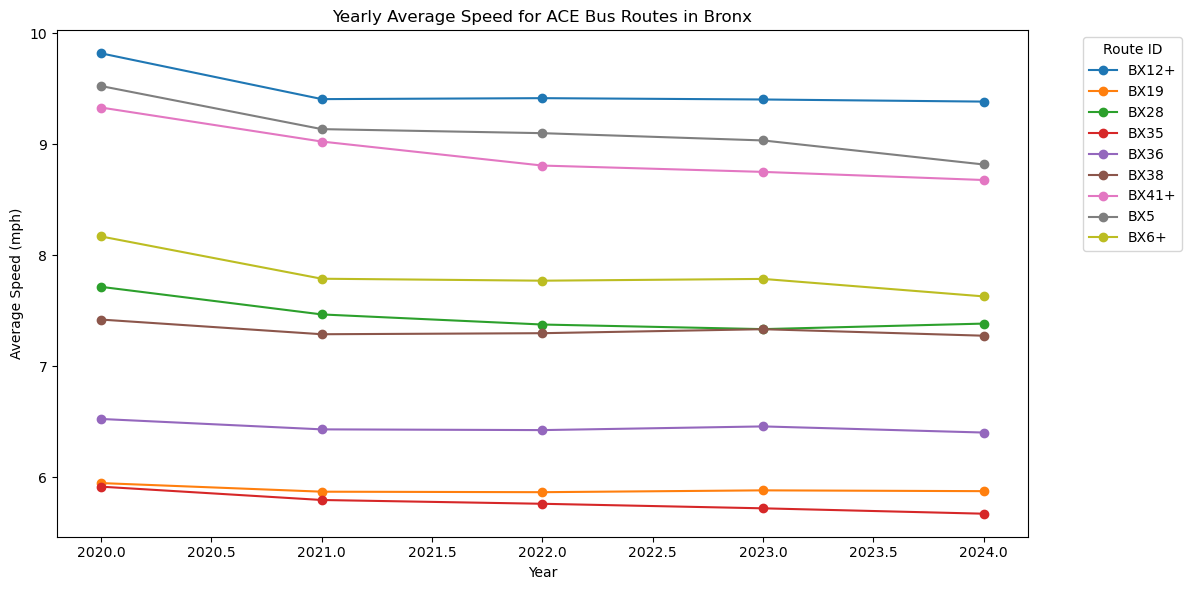

In [92]:
# Lineplot for yearly average speed of ACE buses in the Bronx
ace_buses_speed['month'] = pd.to_datetime(ace_buses_speed['month'], errors='coerce')
ace_buses_speed['year'] = ace_buses_speed['month'].dt.year
bronx_data = ace_buses_speed[ace_buses_speed['borough'].str.lower() == 'bronx']
if not bronx_data.empty:
        avg_speed_yearly = bronx_data.groupby(['route_id', 'year'], as_index=False)['average_speed'].mean()
        plt.figure(figsize=(12, 6))
        for route in avg_speed_yearly['route_id'].unique():
            route_data = avg_speed_yearly[avg_speed_yearly['route_id'] == route]
            plt.plot(route_data['year'], route_data['average_speed'], marker='o', label=str(route))
        plt.title('Yearly Average Speed for ACE Bus Routes in Bronx')
        plt.xlabel('Year')
        plt.ylabel('Average Speed (mph)')
        plt.legend(title='Route ID', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
else:
        print('No ACE bus data found for Bronx borough.')


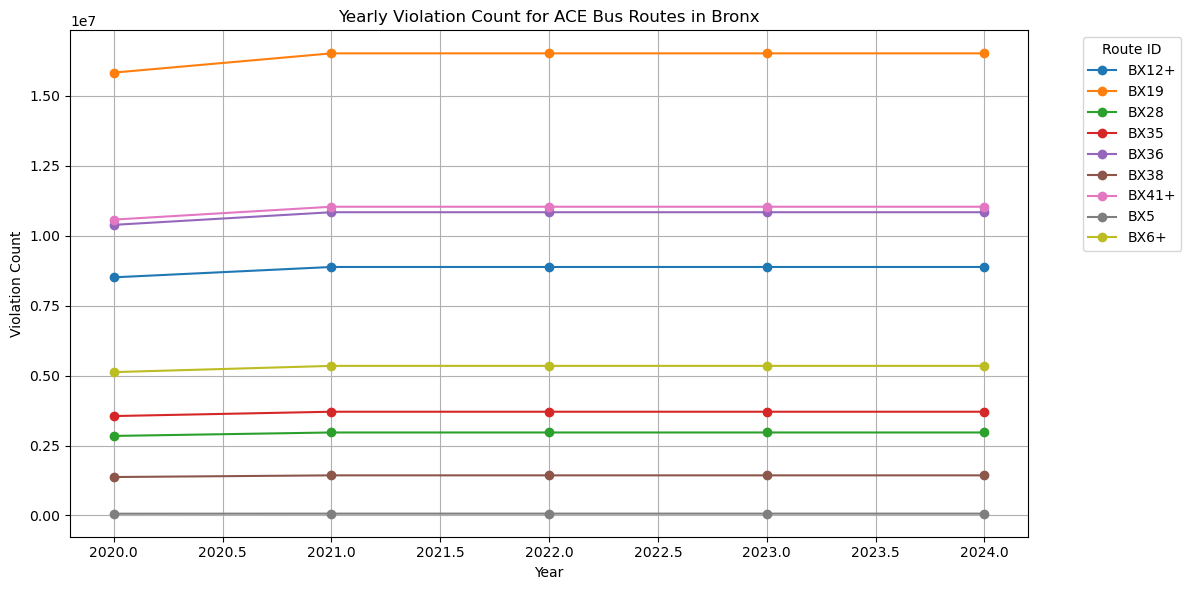

In [93]:
# Yearly violation count for ACE buses in the Bronx with a lineplot
ace_buses_speed['month'] = pd.to_datetime(ace_buses_speed['month'], errors='coerce')
ace_buses_speed['year'] = ace_buses_speed['month'].dt.year
bronx_data = ace_buses_speed[ace_buses_speed['borough'].str.lower() == 'bronx']
if not bronx_data.empty and 'Violation Count' in bronx_data.columns:
    yearly_vio = bronx_data.groupby(['route_id', 'year'], as_index=False)['Violation Count'].sum()
    plt.figure(figsize=(12, 6))
    for route in yearly_vio['route_id'].unique():
        route_data = yearly_vio[yearly_vio['route_id'] == route]
        plt.plot(route_data['year'], route_data['Violation Count'], marker='o', label=str(route))
    plt.title('Yearly Violation Count for ACE Bus Routes in Bronx')
    plt.xlabel('Year')
    plt.ylabel('Violation Count')
    plt.legend(title='Route ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid()
    plt.show()
else:
    print('No ACE bus data found for Bronx borough or Violation Count column missing.')